In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using Printf
using JLD2

  Activating environment at `~/C/code/julia/cmu16745/HW1_S23-main/Project.toml`


# Q2 (20 pts): Augmented Lagrangian Quadratic Program Solver

## Part (A): QP Solver (10 pts)
Here we are going to use the augmented lagrangian method described [here in a video](https://www.youtube.com/watch?v=0x0JD5uO_ZQ), with [the corresponding pdf here](https://github.com/Optimal-Control-16-745/lecture-notebooks-2022/blob/main/misc/AL_tutorial.pdf) to solve the following problem:

$$\begin{align}
\min_x \quad & \frac{1}{2}x^TQx + q^Tx \\ 
\mbox{s.t.}\quad &  Ax -b = 0 \\ 
&  Gx - h \leq 0 
\end{align}$$

where the cost function is described by $Q \in \mathbb{R}^{n \times n}$, $q \in \mathbb{R}^n$, an equality constraint is described by $A \in \mathbb{R}^{m \times n}$ and $b \in \mathbb{R}^m$, and an inequality constraint is described by $G \in \mathbb{R}^{p \times n}$ and $h \in \mathbb{R}^p$.


By introducing a dual variable $\lambda \in \mathbb{R}^m$ for the equality constraint, and $\mu \in \mathbb{R}^p$ for the inequality constraint, we have the following KKT conditions for optimality:

$$\begin{align}
Qx + q + A^T\lambda + G^T \mu &= 0 \quad \quad \text{stationarity}\\ 
Ax-b&= 0 \quad \quad \text{primal feasibility} \\ 
Gx-h&\leq 0 \quad \quad \text{primal feasibility} \\ 
\mu &\geq 0 \quad \quad \text{dual feasibility} \\ 
\mu \circ (Gx - h) &= 0 \quad \quad \text{complementarity}
  \end{align}$$
  where $\circ$ is element-wise multiplication.  

In [30]:
# TODO: read below
# NOTE: DO NOT USE A WHILE LOOP ANYWHERE
"""
The data for the QP is stored in `qp` the following way:
    @load joinpath(@__DIR__, "qp_data.jld2") qp 

which is a NamedTuple, where
    Q, q, A, b, G, h = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h

contains all of the problem data you will need for the QP.

Your job is to make the following function 
    
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)

You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:

as long as solve_qp works. 
"""
function cost(qp::NamedTuple, x::Vector)::Real
    0.5*x'*qp.Q*x + dot(qp.q,x)
end
function c_eq(qp::NamedTuple, x::Vector)::Vector
    qp.A*x - qp.b 
end
function h_ineq(qp::NamedTuple, x::Vector)::Vector
    qp.G*x - qp.h
end
function kkt_conditions(qp::NamedTuple, x::Vector, λ::Vector, μ::Vector)::Vector
    return [FD.gradient(_x->cost(qp,_x),x) + qp.A'*λ + qp.G'*μ;
    c_eq(qp,x);
    #h_ineq(qp,x);
    #μ;
    μ.*h_ineq(qp,x)]
end
function mask_matrix(qp::NamedTuple, x::Vector, μ::Vector, ρ::Real)::Matrix
    h = h_ineq(qp,x)
    Iρ = zeros(length(h),length(h))
    for i=1:length(h)
        if ((h[i]<0) && (μ[i]==0))
            Iρ[i,i] = 0
        else
            Iρ[i,i] = ρ
        end
    end
    return Iρ
    # error("not implemented")
end
function augmented_lagrangian(qp::NamedTuple, x::Vector, λ::Vector, μ::Vector, ρ::Real)::Real
    #error("not implemented")
    c = c_eq(qp,x)
    h = h_ineq(qp,x)
    Iρ = mask_matrix(qp,x,μ,ρ)
    return cost(qp,x) + λ'*c+μ'*h+ ρ/2*dot(c,c) + 0.5*h'*Iρ*h
end
function logging(qp::NamedTuple, main_iter::Int, AL_gradient::Vector, x::Vector, λ::Vector, μ::Vector, ρ::Real)
    # TODO: stationarity norm
    stationarity_norm = norm(FD.gradient(_x->cost(qp,_x),x) + qp.A'*λ + qp.G'*μ) # fill this in 
    @printf("%3d  % 7.2e  % 7.2e  % 7.2e  % 7.2e  % 7.2e  %5.0e\n",
          main_iter, stationarity_norm, norm(AL_gradient), maximum(h_ineq(qp,x)),
          norm(c_eq(qp,x),Inf), abs(dot(μ,h_ineq(qp,x))), ρ)
end
function solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)
    x = zeros(length(qp.q))
    λ = zeros(length(qp.b))
    μ = zeros(length(qp.h))
    ρ = 1
    ϕ = 12

    if verbose
        @printf "iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ\n"
        @printf "----------------------------------------------------------------\n"
    end
    
    # TODO:xxx
    for main_iter = 1:max_iters 
        g = FD.gradient(_x->augmented_lagrangian(qp,_x,λ,μ,ρ),x)
        if norm(g)>=tol
            hess = FD.hessian(_x->augmented_lagrangian(qp,_x,λ,μ,ρ),x)
            x = x - hess\g
        else
            λ = λ + ρ * c_eq(qp,x)
            μ = max.(0,μ + ρ*h_ineq(qp,x))
            ρ = ρ*ϕ
        end
        if verbose
            logging(qp, main_iter, zeros(1), x, λ, μ, 0.0)
        end
        
        # NOTE: when you do your dual update for μ, you should compute
        # your element-wise maximum with `max.(a,b)`, not `max(a,b)`
        # λ = 
        # μ = max.(0,μ+ρ*h_ineq(qp,x))
        # TODO: convergence criteria based on tol  #无穷范数,最大的那个分量小于tol
        if (maximum(h_ineq(qp,x))<tol && norm(c_eq(qp,x),Inf)<tol)
            return x, λ, μ
        end
    end
    error("qp solver did not converge")
end
let 
    # example solving qp 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = true, tol = 1e-8)
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------


  1   4.46e+00   0.00e+00   1.55e+00   1.31e+00   0.00e+00  0e+00
  2   4.92e+00   0.00e+00   5.51e-01   1.27e+00   0.00e+00  0e+00
  3   1.10e-14   0.00e+00   5.51e-01   1.27e+00   4.59e-01  0e+00
  4   5.37e+00   0.00e+00   2.44e-02   2.77e-01   4.70e-02  0e+00
  5   6.94e+00   0.00e+00   2.44e-02   2.77e-01   1.13e-02  0e+00
  6   5.53e+00   0.00e+00   5.11e-03   1.11e-02   9.10e-04  0e+00
  7   5.53e-01   0.00e+00   5.11e-03   1.11e-02   5.93e-03  0e+00
  8   5.37e-01   0.00e+00   6.83e-02   8.95e-05   8.14e-05  0e+00
  9   5.29e-01   0.00e+00   2.11e-05   9.28e-05   6.83e-05  0e+00
 10   7.49e-12   0.00e+00   2.11e-05   9.28e-05   6.16e-05  0e+00
 11   3.03e-04   0.00e+00  -1.58e-09   5.76e-09   3.20e-09  0e+00


([-0.3262308053250364, 0.24943798210595, -0.43226766168620434, -1.417224696457759, -1.3994527418249527, 0.6099582416273239, -0.07312202027485251, 1.303147751391455, 0.5389034783847247, -0.7225813667213112], [-0.12828278934657, -2.8376772230836123, -0.8321998154196744], [0.03638565003981853, 0.0, 0.0, 1.0595060501188005, 0.0])

### QP Solver test

In [31]:
# 10 points 
using Test 
@testset "qp solver" begin 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = false, max_iters = 200, tol = 1e-6)
    
    @load joinpath(@__DIR__, "qp_solutions.jld2") qp_solutions
    @test norm(x - qp_solutions.x,Inf)<1e-3;
    @test norm(λ - qp_solutions.λ,Inf)<1e-3;
    @test norm(μ - qp_solutions.μ,Inf)<1e-3;
end

Test Summary: | Pass  Total
qp solver     |    3      3


Test.DefaultTestSet("qp solver", Any[], 3, false, false)

# Simulating a Falling Brick with QPs
In this question we'll be simulating a brick falling and sliding on ice in 2D. You will show that this problem can be formulated as a QP, which you will solve using an Augmented Lagrangian method.

## The Dynamics
The dynamics of the brick can be written in continuous time as
$$ M \dot{v}  + M g = J^T \lambda \\ \text{ where } M = mI_{2\times 2}, \; g = \begin{bmatrix} 0 \\ 9.81 \end{bmatrix},\; J = \begin{bmatrix} 0 & 1 \end{bmatrix} $$
and $\lambda \in \mathbb{R}$ is the normal force. The velocity $v \in \mathbb{R}^2$ and position $q \in \mathbb{R}^2$ are composed of the horizontal and vertical components.

We can discretize the dynamics with backward Euler:
$$ \begin{bmatrix} v_{k+1} \\ q_{k+1} \end{bmatrix} = \begin{bmatrix} v_k \\ q_k \end{bmatrix}
+ \Delta t \cdot [1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1]\begin{bmatrix} \frac{1}{m} J^T \lambda_{k+1} - g \\ v_{k+1} \end{bmatrix}[1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1]\begin{bmatrix} \frac{1}{m} J^T \lambda_{k+1} - g \\ v_{k+1} \end{bmatrix}[1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1]\begin{bmatrix} \frac{1}{m} J^T \lambda_{k+1} - g \\ v_{k+1} \end{bmatrix}[1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1][1mJTλk+1−gvk+1]\begin{bmatrix} \frac{1}{m} J^T \lambda_{k+1} - g \\ v_{k+1} \end{bmatrix}$$

We also have the following contact constraints:
$$ \begin{align}
J q_{k+1} &\geq 0 &&\text{(don't fall through the ice)} \\
\lambda_{k+1} &\geq 0 &&\text{(normal forces only push, not pull)} \\
\lambda_{k+1} J q_{k+1} &= 0 &&\text{(no force at a distance)}
\end{align} $$

## Part (B): QP formulation for Falling Brick (5 pts)
Show that these discrete-time dynamics are equivalent to the following QP by writing down the KKT conditions.

$$ \begin{align}
    &\text{minimize}_{v_{k+1}} && \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} \\
    &\text{subject to} && -J(q_k + \Delta t \cdot v_{k+1}) \leq 0 \\
\end{align} $$

**TASK**: Write down the KKT conditions for the optimization problem above, and show that it's equivalent to the dynamics problem stated previously. Use LaTeX markdown.

**PUT ANSWER HERE:**
$$ \begin{align}
    M v_{k+1} + M(\Delta t g-v_{k}) - (J \Delta t)^{T}\lambda =0 && (stationarity) \\
    -J (q_{k+1} + \Delta t v_{k+1}) \leq 0 && (primal feasibility) \\
    \lambda \geq && (dual feasibility) \\
    \lambda \circ (J q_{k} + \Delta t\cdot v_{k+1})=0 &&  (\text{按元素乘积})\\
\end{align}
$$

在此基础之上,stationarity条件可化为
$$ \begin{align}
    v_{k+1} = v_{k} + \Delta t(\frac{1}{M} J^{T} \lambda -g) \\
\end{align}
$$
得到了状态方程的第一行,并令:
$$
    q_{k+1} = q_{k} + \Delta t v_{k+1}
$$
则有以下成立:
$$\begin{align}
    J q_{k+1} \geq 0 \\
    \lambda_{k+1} = \lambda \geq 0 \\
    \lambda_{k+1} J q_{k+1} = 0 \\
\end{align}
$$

## Part (C): Brick Simulation (5 pts)

In [46]:
function brick_simulation_qp(q, v; mass = 1.0, Δt = 0.01)
    
    # TODO: fill in the QP problem data for a simulation step 
    # fill in Q, q, G, h, but leave A, b the same 
    # this is because there are no equality constraints in this qp 
    #qk = q
    M =  mass*diagm(ones(2)) ## 为什么 Diagonal不行 https://web.eecs.umich.edu/~fessler/course/551/julia/tutor/03-diag.html
    J = [0 1]
    g = [0; 9.81]
    qp = (
        Q = M, 
        q = M*(Δt*g - v),
        A = zeros(0,2), # don't edit this
        b = zeros(0),   # don't edit this 
        G = -J*Δt,
        h = J*q
    )
    
    return qp 
end

brick_simulation_qp (generic function with 1 method)

In [47]:
@testset "brick qp" begin 
    
    q = [1,3.0]
    v = [2,-3.0]
    
    qp = brick_simulation_qp(q,v)
    
    # check all the types to make sure they're right
    qp.Q::Matrix{Float64}
    qp.q::Vector{Float64}
    qp.A::Matrix{Float64}
    qp.b::Vector{Float64}
    qp.G::Matrix{Float64}
    qp.h::Vector{Float64}
    
    @test size(qp.Q) == (2,2)
    @test size(qp.q) == (2,)
    @test size(qp.A) == (0,2)
    @test size(qp.b) == (0,)
    @test size(qp.G) == (1,2)
    @test size(qp.h) == (1,)
    
    @test abs(tr(qp.Q) - 2) < 1e-10
    @test norm(qp.q - [-2.0, 3.0981]) < 1e-10 
    @test norm(qp.G - [0 -.01]) < 1e-10 
    @test abs(qp.h[1] -3) < 1e-10
    
end

Test Summary: | Pass  Total
brick qp      |   10     10


Test.DefaultTestSet("brick qp", Any[], 10, false, false)

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -1.04e+00   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -1.09e+00   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -1.13e+00   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -1.17e+00   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -1.21e+00   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     m

  1   0.00e+00   0.00e+00  -1.99e+00   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -1.99e+00   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -1.98e+00   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -1.97e+00   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -1.96e+00   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -1.

----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -4.37e-01   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -3.81e-01   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -3.24e-01   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -2.66e-01   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00  -2.07e-01   0.00e+00   0.00e+00  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
------------------------------

  2   2.51e-18   0.00e+00   1.00e-03   0.00e+00   1.00e-06  0e+00
  3   1.20e-04   0.00e+00   1.00e-03   0.00e+00   1.00e-06  0e+00
  4   6.80e-18   0.00e+00   1.00e-03   0.00e+00   1.30e-05  0e+00
  5   1.42e-03   0.00e+00   9.85e-04   0.00e+00   1.28e-05  0e+00
  6   0.00e+00   0.00e+00   9.85e-04   0.00e+00   1.53e-04  0e+00
  7   1.45e-02   0.00e+00   8.40e-04   0.00e+00   1.30e-04  0e+00
  8   0.00e+00   0.00e+00   8.40e-04   0.00e+00   1.35e-03  0e+00
  9   5.67e-02   0.00e+00   2.73e-04   0.00e+00   4.39e-04  0e+00
 10   1.39e-17   0.00e+00   2.73e-04   0.00e+00   1.99e-03  0e+00
 11   2.63e-02   0.00e+00   1.06e-05   0.00e+00   7.68e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.92e-06   0.00e+00   9.92e-04   0.00e+00   0.00e+00  0e+00
  2   8.09e-18   0.00e+00   9.92e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   3.20e-18

  2   4.87e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.71e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   1.95e-18   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   0.00e+00   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.87e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.65e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18   0.00e+00   9.90e-04   0.00e+00   1.27e-05  0e+00
  5   1.41e-03   0.00e+00   9.76e-04   0.00e+00   1.26e-05  0e+00
  6   8.67e-19   0.00e+00   9.76e-04   0.00e+00   1.50e-04  0e+00
  7   1.44e-02   0.00e+00   8.32e-04   0.00e+00   1.28e-04  0e+00
  8   6.94e-18   0.00e+00   8.32e-04   0.00e+00   1.32e-03  0e+00
  9   5.62e-02   0.00e+00   2.71e-04   0.00e+00   4.31e-04  0e+00
 10   1.39e-17   0.00e+00   2.71e-04   0.00e+00   1.95e-03  0e+00
 11   2.60e-02   0.00e+00   1.05e-05   0.00e+00   7.54e-05  0e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   9.91e-06   0.00e+00   9.91e-04   0.00e+00   0.00e+00  0e+00
  2   4.89e-18   0.00e+00   9.91e-04   0.00e+00   9.83e-07  0e+00
  3   1.19e-04   0.00e+00   9.90e-04   0.00e+00   9.82e-07  0e+00
  4   1.49e-18

Test Passed
#= /Users/yi/C/code/julia/cmu16745/HW1_S23-main/Q3.ipynb:30 =# @test(minimum(ys) > -0.01) = Test Passed
#= /Users/yi/C/code/julia/cmu16745/HW1_S23-main/Q3.ipynb:31 =# @test(abs(xs[end] - 3) < 0.01) = Test Passed


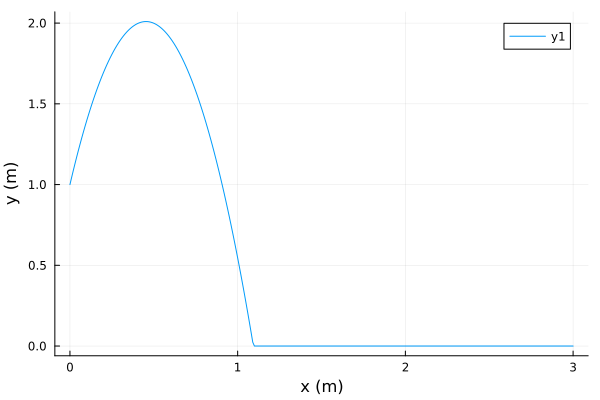

#= /Users/yi/C/code/julia/cmu16745/HW1_S23-main/Q3.ipynb:34 =# @test(maximum(xdot) < 1.0001) = Test Passed
#= /Users/yi/C/code/julia/cmu16745/HW1_S23-main/Q3.ipynb:35 =# @test(minimum(xdot) > 0.9999) = Test Passed
#= /Users/yi/C/code/julia/cmu16745/HW1_S23-main/Q3.ipynb:36 =# @test(ys[110] > 0.01) = Test Passed
#= /Users/yi/C/code/julia/cmu16745/HW1_S23-main/Q3.ipynb:37 =# @test(abs(ys[111]) < 0.01) = Test Passed
#= /Users/yi/C/code/julia/cmu16745/HW1_S23-main/Q3.ipynb:38 =# @test(abs(ys[112]) < 0.01) = Test Passed


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /Users/yi/.julia/packages/MeshCat/vWPbP/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("brick" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x72, 0x69, 0x63, 0x6b], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8702))

In [50]:
include(joinpath(@__DIR__, "animate_brick.jl"))
let 
    
    dt = 0.01 
    T = 3.0 
    
    t_vec = 0:dt:T
    N = length(t_vec)
    
    qs = [zeros(2) for i = 1:N]
    vs = [zeros(2) for i = 1:N]
    
    qs[1] = [0, 1.0]
    vs[1] = [1, 4.5]
    
    # TODO: simulate the brick by forming and solving a qp 
    # at each timestep. Your QP should solve for vs[k+1], and
    # you should use this to update qs[k+1]
    # function solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)
    for i in 1:(N-1)
        qp = brick_simulation_qp(qs[i],vs[i])
        vs[i+1],_,_ = solve_qp(qp;verbose=true,max_iters=100,tol=1e-4)
        qs[i+1] = qs[i] + vs[i+1] *dt
    end
    
    xs = [q[1] for q in qs]
    ys = [q[2] for q in qs]
    
    @show @test abs(maximum(ys)-2)<1e-1
    @show @test minimum(ys) > -1e-2
    @show @test abs(xs[end] - 3) < 1e-2
    
    xdot = diff(xs)/dt
    @show @test maximum(xdot) < 1.0001
    @show @test minimum(xdot) > 0.9999
    @show @test ys[110] > 1e-2
    @show @test abs(ys[111]) < 1e-2
    @show @test abs(ys[112]) < 1e-2
    
    display(plot(xs, ys, ylabel = "y (m)", xlabel = "x (m)"))
    
    animate_brick(qs)
    
    
    
end